# Cholera

In [1]:
import jax
import itertools
import numpy as onp

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *

import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2023-09-05 15:36:42.938088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [3]:
pfilter(theta, ys, 10000, covars, thresh=-1)

Array(3747.8354, dtype=float32)

In [3]:
state = rinit(theta, 1, covars).squeeze()
keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(2)])
print(rprocess(np.array([state, state]), theta, keys, covars)) 
print(rprocesses(np.array([state, state]), np.array([theta, theta]), keys, covars))

[[1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]
 [1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]]
[[1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]
 [1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]]


In [5]:
print(dmeasure(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars) for i in range(20)]), theta))
print(dmeasures(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars) for i in range(20)]), 
         np.vstack([theta+i for i in range(20)])))

[-7.851351  -7.815332  -7.781214  -7.7489424 -7.718454  -7.6896853
 -7.662572  -7.6370473 -7.613046  -7.590501  -7.5693474 -7.549519
 -7.5309525 -7.537484  -7.544163  -7.5509915 -7.5579705 -7.5651026
 -7.572391  -7.5798388]
[ -7.851351  -8.860641  -9.62187  -10.173655 -10.603394 -10.954595
 -11.251214 -11.507751 -11.733632 -11.935319 -12.117439 -12.283416
 -12.435852 -12.585667 -12.725382 -12.856299 -12.979485 -13.095823
 -13.206053 -13.310804]


In [8]:
thetas = theta + 1e-3*np.abs(theta)*onp.random.normal(size=theta.shape)
perfilter(thetas, ys, 1000, np.abs(theta)/100, covars=covars, a=0.9, thresh=0)

(Array(4261.8037, dtype=float32),
 Array([[  3.7366014,  -2.3886294,         nan, ...,  -2.799066 ,
         -12.556817 ,  -3.7673175],
        [  3.7366014,  -2.3886294,         nan, ...,  -2.799066 ,
         -12.556817 ,  -3.7673175],
        [  3.6644979,  -2.403528 ,         nan, ...,  -2.7425282,
         -12.563065 ,  -3.6966836],
        ...,
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156],
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156],
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156]], dtype=float32))

In [9]:
dmeas(2641, np.array([1.658749e+06, 2.427019e+05,  0.000000e+00, 3.005136e+03]), theta)

Array(-7.5961165, dtype=float32)

In [10]:
jax.scipy.stats.norm.logpdf(2641, loc=3.005136e+03, scale=0.23*3.005136e+03)

Array(-7.5961165, dtype=float32, weak_type=True)

In [66]:


dmeas(2641, np.array([1.626465e+06, 2.960543e+05, 0.000000e+00, 2.884684e+03]), theta)

Array(-7.483882, dtype=float32)

In [3]:
n_trials = 100
J = 10000

def get_rand_theta():
    return transform_thetas(onp.random.uniform(10.00, 40.00),
                onp.random.uniform(0.03, 0.60), 
                         rho, 
                 onp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                 onp.random.uniform(-1.00, 0.00)*0.01, 
                 onp.random.uniform(1.00, 5.00), 
                 onp.random.uniform(0.10, 0.50), 
                 onp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                 onp.random.uniform(-10,0,size=6))

def get_rand_theta(J=J):
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    rands = onp.array(onp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~onp.isinf(lows)] = onp.random.uniform(lows[~onp.isinf(lows)], 
                       highs[~onp.isinf(highs)],
                       size=(J, len(highs[~onp.isinf(highs)]))).T
    return rands.T
                       
                       


sigmas = (np.abs(theta)/600)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
#theta_ests = get_rand_theta(J).mean(0)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
print(pfilter(theta_ests, ys, J, covars, thresh=-1))
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

3935.0286


(Array(26.195042, dtype=float32),
 Array(0.05506924, dtype=float32),
 Array(nan, dtype=float32),
 Array(20.949745, dtype=float32),
 Array(0.01689098, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.0049051, dtype=float32),
 Array(2.7719014, dtype=float32),
 Array(0.23420441, dtype=float32),
 Array([ 0.7477923,  6.68701  , -3.2926204,  3.9615188,  3.3294454,
         4.446201 ], dtype=float32),
 Array([-1.560243 , -2.3884418, -3.2203848, -4.5535836, -8.827789 ,
        -4.8480263], dtype=float32),
 3,
 0.02)

100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


(array([29.,  8.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([3778.68652344, 4073.30566406, 4367.92480469, 4662.54394531,
        4957.16308594, 5251.78222656, 5546.40185547, 5841.02099609,
        6135.64013672, 6430.25927734, 6724.87841797]),
 <BarContainer object of 10 artists>)

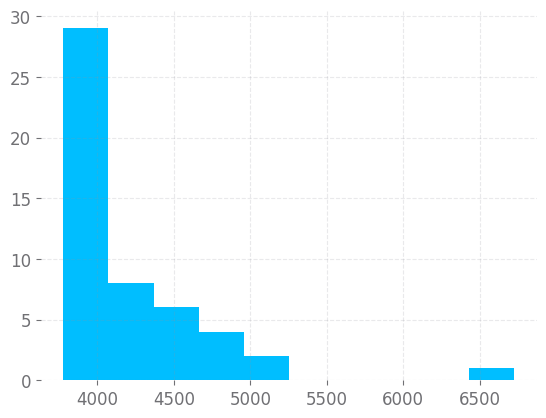

In [62]:
perturbs = [pfilter(theta + 60*sigmas*onp.random.normal(size=theta.shape), 
         ys, J, covars, -1) for i in tqdm(range(50))]
plt.hist(perturbs)

In [ ]:
newt_logliks, newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-1, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='Newton', scale=False, ls=True)

In [ ]:
weighted_newt_logliks, weighted_newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='WeightedNewton', scale=False, ls=True)

In [ ]:
#make plot of runtime of backward pass vs number of particles and number of timesteps

#try adaptive swapping between IF2 and AD
#Benchmark local search when MLE found, for swapping to AD to be worth it

In [ ]:
bfgs_logliks, bfgs_ests = train(theta_ests, ys, covars, beta=0.9*10, 
                                eta=np.flip(np.linspace(0.0001,0.2,40)), 
                                c=0.01, max_ls_itn=8, 
                            verbose=True, itns=40, J=J, thresh=0, method='BFGS', scale=True, ls=False)

In [ ]:
mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 60*sigmas, covars=covars, verbose=True,
                              M=40, J=J, a=0.99, monitor=True, thresh=-1)

In [ ]:
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,40)), 
                            verbose=True, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)

In [ ]:
mif_logliks, mif_params = mif(get_rand_theta(), ys, sigmas=0.02, 
                              sigmas_init = 1e-20, covars=covars, verbose=True,
                              M=40, J=J, a=0.95, monitor=True, thresh=-1)

In [20]:
rinits(get_rand_theta(), 1, covars).squeeze().shape

(10000, 9)

In [22]:
dmeasures(ys[0], rinits(get_rand_theta(), 1, covars).squeeze(), get_rand_theta()).shape

(10000,)

In [ ]:
gd_logliks, gd_ests = train(mif_params[mif_logliks.argmin()].mean(0), ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.01,0.2,100)), 
                            verbose=True, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) #np.flip(np.linspace(0.0001,0.2,40) for nbhd

In [ ]:
n_trials = 100
J = 10000
close = False


#bbox = np.load('bbox.npy')

original_logliks = []
original_theta_ests = []
mif_logliks_trials = []
mif_params_trials = []
mif_logliks_warm_trials = []
mif_params_warm_trials = []
gd_logliks_trials = []
gd_ests_trials = []

for trial in tqdm(range(n_trials)):
    
    if close:
        sigmas = (np.abs(theta)/600)
        theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
        orig_loglik = pfilter(theta_ests, ys, J, covars, thresh=-1)
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,40)), 
                            verbose=False, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)
    else:
        bbox = get_rand_theta(1).squeeze()# np.array([get_rand_theta() for j in tqdm(range(J))])
        orig_loglik = pfilter(bbox, ys, J, covars, thresh=-1)
        mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=40, J=J, a=0.95, monitor=True, thresh=-1)
        theta_ests = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,60)), 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) 
        mif_logliks = mif_logliks_warm
        mif_params = mif_params_warm
        
        #mif_logliks, mif_params = mif(bbox, ys, sigmas=0.02, 
        #                          sigmas_init = 1e-20, covars=covars, verbose=False,
        #                          M=100, J=J, a=0.99, monitor=True, thresh=-1)
        

    #theta_ests = bbox[trial]
    #
    '''
    mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 60*sigmas, covars=covars, verbose=False,
                              M=40, J=J, a=0.99, monitor=True, thresh=-1)
                              
    
    '''
    
    
    original_logliks.append(orig_loglik)
    original_theta_ests.append(theta_ests)
    
    
    outf = open('outs/trials'+str(trial)+'.txt', 'w')
    outf.write(str(trial) + 'orig ' + str(orig_loglik) + ' gd ' + str(gd_logliks[-1]) + ' , ' + str(min(gd_logliks)) + ' mif ' + str(mif_logliks[-1]) + ' , ' + str(min(mif_logliks)))
    
    print('orig', orig_loglik, 'gd', min(gd_logliks), 'if2', min(mif_logliks))
    
    #mif_logliks_trials.append(mif_logliks)
    #mif_params_trials.append(mif_params)
    
    mif_logliks_warm_trials.append(mif_logliks_warm)
    mif_params_warm_trials.append(mif_params_warm)
    
    gd_logliks_trials.append(gd_logliks)
    gd_ests_trials.append(gd_ests)
    
    
    

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

In [110]:
0.01*0.97**100

0.0004755250792540563

Text(0, 0.5, 'ADPF Log-Likelihood')

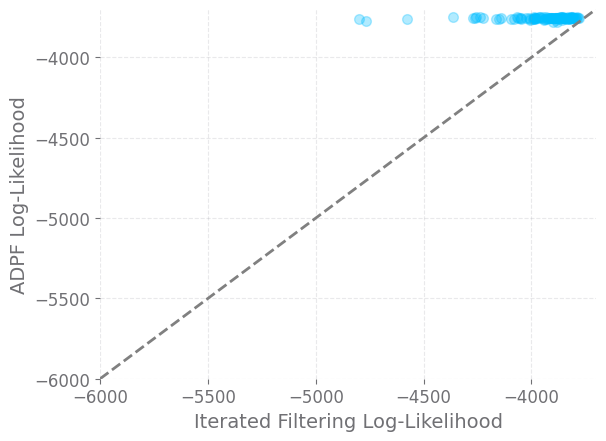

In [44]:
plt.scatter(-(np.array(mif_logliks_trials).min(-1)), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.3)
lo, hi = -6000, -3700
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')

Text(0, 0.5, 'Count')

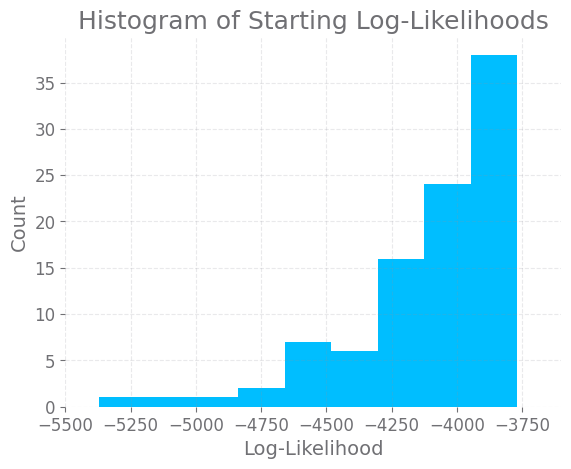

In [96]:
plt.hist(-(np.array(original_logliks)), bins='auto')
plt.xlim(-5500,-3600)
plt.title('Histogram of Starting Log-Likelihoods')
plt.xlabel('Log-Likelihood')
plt.ylabel('Count')

In [ ]:
# 2 experiments:
# 1. Run POMP IF2 from same perturbed normal starting values, compare with ADPF
# 2. Run POMP IF2, then initialize ADPF from IF2 estimates

# Implement fitting of ivps, include in thetas

In [132]:
result.keys()

odict_keys(['m1.in', 'm1.out', 'm1.lik', 'etime1', 'm2.in', 'm2.out', 'm2.lik', 'etime2'])

In [40]:
get_thetas(theta_ests + 0.002 * onp.random.normal(size=theta_ests.shape))

(Array(17.157778, dtype=float32),
 Array(0.08470614, dtype=float32),
 Array(0., dtype=float32),
 Array(17.212324, dtype=float32),
 Array(0.00931086, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00464967, dtype=float32),
 Array(2.8722932, dtype=float32),
 Array(0.38165185, dtype=float32),
 Array([ 0.64628214,  6.587917  , -3.5837886 ,  4.5165987 ,  2.61891   ,
         3.425333  ], dtype=float32),
 Array([-1.8153721, -2.790865 , -3.1247826, -4.425585 , -9.491348 ,
        -4.1355324], dtype=float32),
 3,
 0.02)

In [133]:
result['m2.out']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
gamma,10.147432,12.840196,16.393051,31.380827,14.553011,19.121580,12.586368,16.053342,16.883333,12.897271,...,12.450948,16.494988,18.259771,15.869915,37.815757,17.497809,14.469121,18.196580,12.024921,10.033183
eps,22.975832,23.492511,50.693063,34.313590,41.781277,44.869108,0.029021,58.153201,74.727619,0.963168,...,45.939555,59.437261,57.134900,0.735601,90.408711,80.707782,14.894382,67.697825,65.095423,0.682013
rho,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delta,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
deltaI,0.030934,0.035780,0.036091,0.062355,0.039320,0.036448,0.617223,0.031483,0.031772,1.508487,...,0.035776,0.035341,0.030793,0.822606,0.046820,0.030250,0.043111,0.034001,0.031093,0.320543
clin,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
alpha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
beta.trend,-0.021903,-0.018335,-0.016180,-0.012464,-0.010684,-0.014702,-0.036403,-0.018075,-0.014541,-0.015335,...,-0.016238,-0.018554,-0.009034,-0.015799,-0.015843,-0.012749,-0.010205,-0.013474,-0.018533,-0.017289
log.beta1,-6.583138,-3.723951,-0.768365,2.121580,-0.912669,0.189370,1.798472,-0.312464,-0.238840,-2.364838,...,-1.789512,0.365149,0.960509,1.508640,2.119661,0.865721,-0.285626,0.297857,-3.464735,-2.668802
log.beta2,10.216940,10.311177,7.185976,5.377011,8.006736,6.947330,8.331496,7.124780,6.864187,5.106505,...,8.098172,6.750041,6.463979,5.116031,5.570265,6.564288,7.763336,6.642992,10.319295,9.849682


Text(0.5, 1.0, 'Performance of ADPF Close to the MLE')

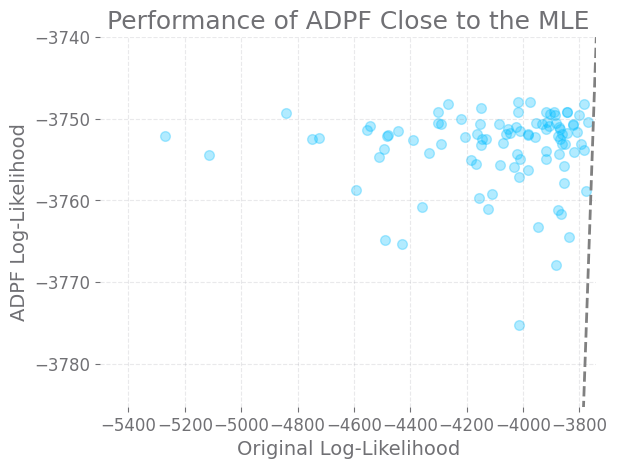

In [127]:
xs = -(np.array(original_logliks))
ys = -(np.array(gd_logliks_trials)[:,-1])

plt.scatter(xs, ys, marker='o', alpha=0.3)
plt.scatter(xs[xs > ys], ys[xs > ys], marker='x', alpha=0.3, color='r')
lo, hi = -5500, -3740
plt.xlim(lo, hi)
plt.ylim(np.min(ys)-10,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Original Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Performance of ADPF Close to the MLE')

In [ ]:
result

Text(0.5, 1.0, 'Comparison of ADPF and IF2 Performance')

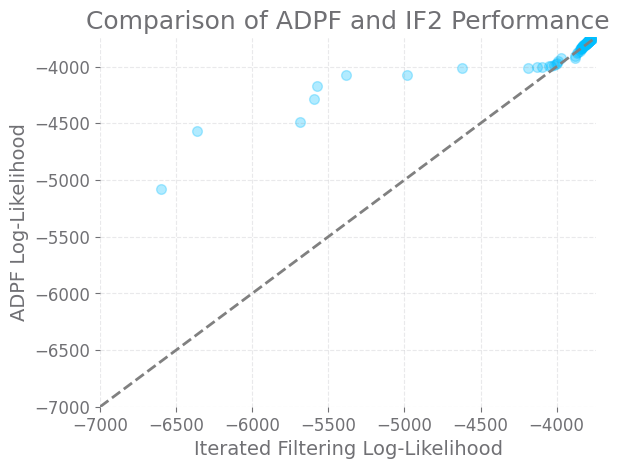

In [17]:
# Initialized with single uniform draw per iteration
import pyreadr
from scipy.special import logsumexp
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
plt.scatter(np.sort(logsumexp(result['m2.lik'], axis=0)), np.sort(-(np.array(gd_logliks_trials)[:,-1])), marker='o', alpha=0.3)
lo, hi = -7000, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Comparison of ADPF and IF2 Performance')

Text(0.5, 1.0, 'Comparison of ADPF and IF2 Performance')

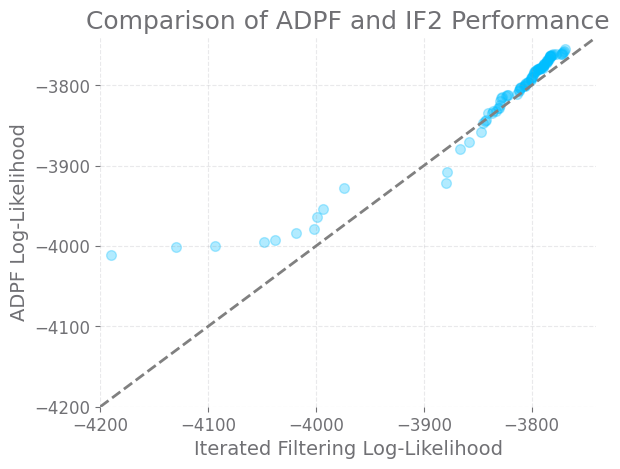

In [15]:
# Initialized with single uniform draw per iteration
import pyreadr
from scipy.special import logsumexp
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
plt.scatter(np.sort(logsumexp(result['m2.lik'], axis=0)), np.sort(-(np.array(gd_logliks_trials)[:,-1])), marker='o', alpha=0.3)
lo, hi = -4200, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Comparison of ADPF and IF2 Performance')

Text(0.5, 1.0, 'Comparison of ADPF and IF2 Performance')

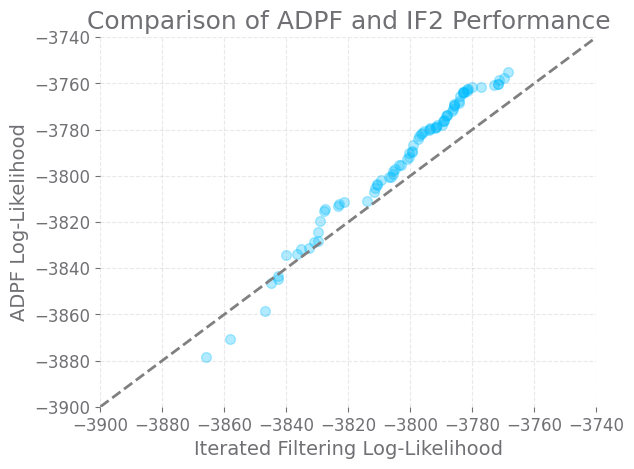

In [18]:
# Initialized with single uniform draw per iteration
import pyreadr
from scipy.special import logsumexp
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
plt.scatter(np.sort(logsumexp(result['m2.lik'], axis=0)), np.sort(-(np.array(gd_logliks_trials)[:,-1])), marker='o', alpha=0.3)
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Comparison of ADPF and IF2 Performance')

Text(0.5, 1.0, 'Comparison of ADPF and IF2 Performance')

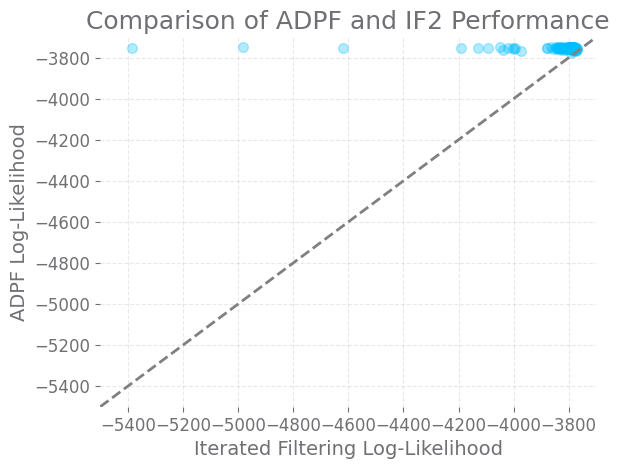

In [128]:
# Initialized from J uniform draws on bbox
import pyreadr
from scipy.special import logsumexp
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
plt.scatter((logsumexp(result['m2.lik'], axis=0)), (-(np.array(gd_logliks_trials)[:,-1])), marker='o', alpha=0.3)
lo, hi = -5500, -3700
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Comparison of ADPF and IF2 Performance')

Text(0.5, 1.0, 'Comparison of ADPF and IF2 Performance')

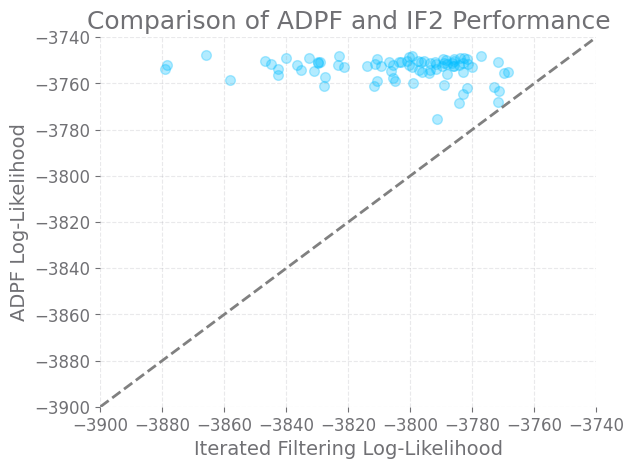

In [130]:
# Initialized from J uniform draws on bbox
import pyreadr
from scipy.special import logsumexp
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
plt.scatter((logsumexp(result['m2.lik'], axis=0)), (-(np.array(gd_logliks_trials)[:,-1])), marker='o', alpha=0.3)
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')
plt.title('Comparison of ADPF and IF2 Performance')

In [ ]:
# autodiff is central to many scientific applications and advances
# it has not made its way to POMPs and the particle filter 
# recently it has been shown that black-box libraries can differentiate through PF with a small tweak,
#    and that this corresponds to the REINFORCE estimator from Poyiadjis
# previously success has been limited in applying this to real-world problems, 
#    especially ones that need the plug-and-play property
# we create a smooth extension to the particle filter, by formally constructing a derivative,
#    by constructing a properly-weighted off-policy extension of the particle filter
#        with differentiable weights, and show that when evaluating on-policy,
#        DPF coincides with an estimator of the unique derivative under the seed
# we show consistency and concentration of the Poyiadjis estimator,
#    as well as provide a rate of convergence of the optimization procedure using it.
# while we use the Poyiadjis estimator and SW procedure to obtain it in practice,
#    they didn't have the theory or details of a successful optimization implementation
# we therefore leverage DPF to algorithmically implement this
#    algorithmically, a key ingredient to it working well is the gradient norm
#    we demonstrate that this works well on interesting problems
#    and show that we only need 20 epochs and not the 500 they use
# we show that we only need a simulator to implement this
# we formally show that DPF is equivalent to the derivative
# we show that this can be thought of as an analogue to mini-batch GD
# we show that GPU speedups enable trivial parallelization and fast computation

# provide pseudocode for actual practical algorithm and theoretical algorithm

Text(0, 0.5, 'ADPF Log-Likelihood')

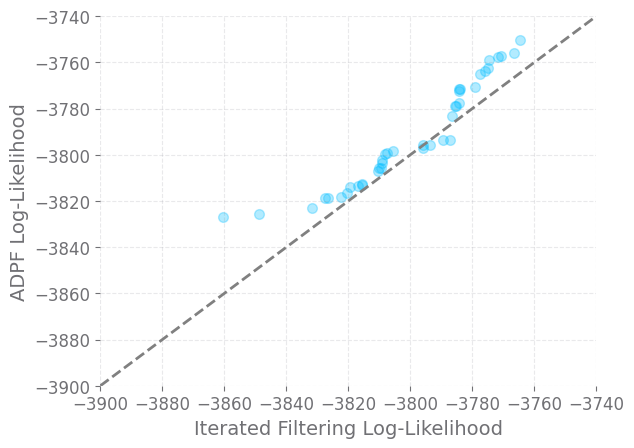

In [46]:
# Both initialized from J uniform draws on bbox
import pyreadr
from scipy.special import logsumexp
plt.scatter(np.sort(-(np.array(mif_logliks_trials).min(-1))), 
            np.sort(-(np.array(gd_logliks_trials).min(-1))), marker='o', alpha=0.3)
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')

Text(0, 0.5, 'ADPF Log-Likelihood')

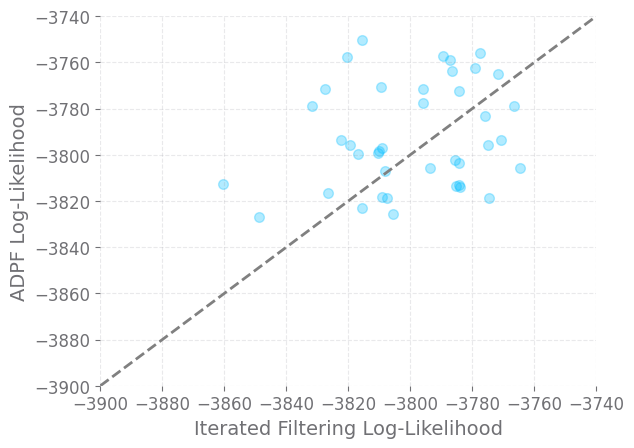

In [47]:
# Both initialized from J uniform draws on bbox
import pyreadr
from scipy.special import logsumexp
plt.scatter(-(np.array(mif_logliks_trials).min(-1)), 
            -(np.array(gd_logliks_trials).min(-1)), marker='o', alpha=0.3)
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.xlabel('Iterated Filtering Log-Likelihood')
plt.ylabel('ADPF Log-Likelihood')

In [ ]:
np.array(mif_logliks).shap

In [7]:
np.array(gd_logliks_trials).shape

(100, 41)

In [10]:
trial

9

NameError: name 'gd_logliks' is not defined

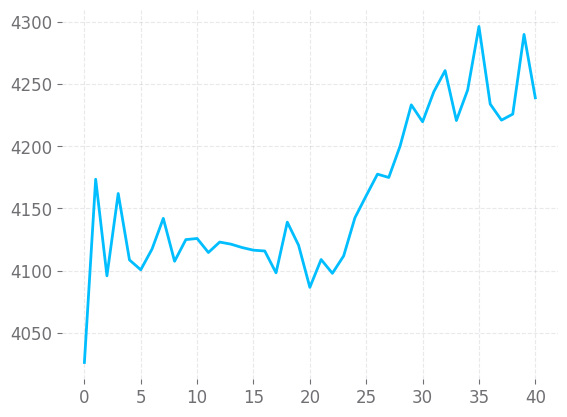

In [7]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
plt.yscale('log')
#plt.plot(bfgs_logliks)

NameError: name 'gd_logliks' is not defined

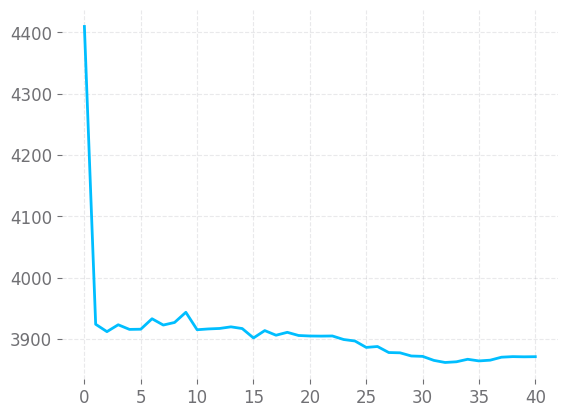

In [6]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
plt.yscale('log')
#plt.plot(bfgs_logliks)

In [ ]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=sigmas, 
                                       sigmas_init = sigmas, covars=covars, 
                                       M=100, J=J, Jh=500, a=0.95, beta=0.9, tau=5, 
                                       monitor=True, verbose=True, thresh=0)

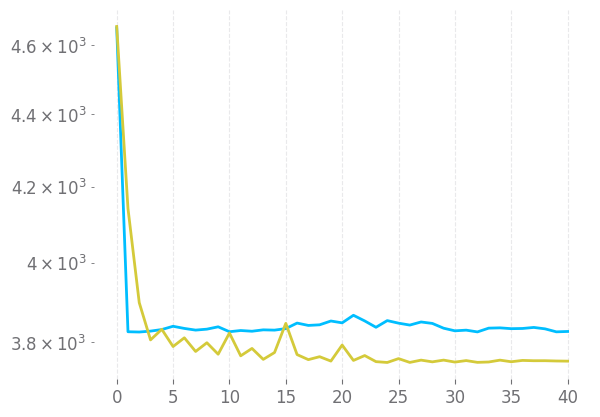

In [190]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
plt.yscale('log')
#plt.plot(bfgs_logliks)

In [195]:
get_thetas(theta)

(Array(20.799997, dtype=float32),
 Array(0.06, dtype=float32),
 Array(0., dtype=float32),
 Array(19.1, dtype=float32),
 Array(0.011109, dtype=float32),
 Array(1., dtype=float32),
 Array(-0.00498, dtype=float32),
 Array(3.1299999, dtype=float32),
 Array(0.23, dtype=float32),
 Array([ 0.747,  6.38 , -3.44 ,  4.23 ,  3.33 ,  4.55 ], dtype=float32),
 Array([-1.6928196, -2.5433836, -2.8404393, -4.6918178, -8.477972 ,
        -4.390059 ], dtype=float32),
 3,
 0.02)

In [193]:
get_thetas(gd_ests[-1])

(Array(19.771534, dtype=float32),
 Array(0.04795394, dtype=float32),
 Array(nan, dtype=float32),
 Array(30.42206, dtype=float32),
 Array(0.02109968, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00539798, dtype=float32),
 Array(3.1755683, dtype=float32),
 Array(0.22505966, dtype=float32),
 Array([ 0.41123822,  6.6049023 , -3.549537  ,  4.447134  ,  3.167178  ,
         4.790889  ], dtype=float32),
 Array([-1.3741418, -2.1307862, -2.7551465, -4.1404977, -8.628193 ,
        -5.0305376], dtype=float32),
 3,
 0.02)

In [134]:
pd.DataFrame([newt_logliks, weighted_newt_logliks, bfgs_logliks, gd_logliks, mif_logliks, newtif_logliks], 
             index=['Newton', 'Weighted Newton', 'Quasi-Newton', 'Gradient Descent', 'IF2', 'Newton IF2']
            ).T.to_csv('data/dacca/fit1.csv')

In [81]:
#params = mif_params[-1].mean(0)
params = theta
traj = [rinit(params, 1, covars)]
for i in tqdm(range(len(ys))):
    traj.append(rprocess(traj[-1], params, 
                         np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(1)]), covars))
traj = traj[1:]

100%|██████████| 600/600 [00:00<00:00, 1429.17it/s]


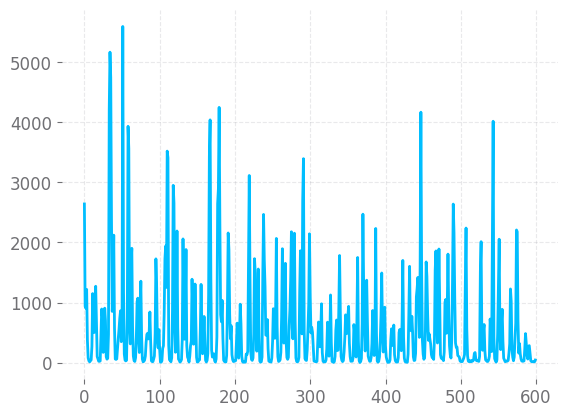

In [74]:
plt.plot(ys)

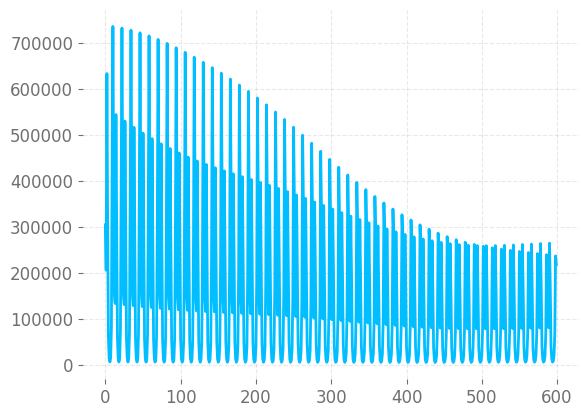

In [83]:
plt.plot(onp.array([onp.array(traj)[:,i,1] for i in range(1)]).T)
plt.ticklabel_format(style='plain') 
plt.show()

In [72]:
def rproc_debug(state, theta, key, covar):
    S, I, Y, deaths, pts, t = state[0], state[1], state[2], state[3], state[4:-1], state[-1]
    t = t.astype(int)
    trends, dpopdts, pops, seass = covar[:,0], covar[:,1], covar[:,2], covar[:,3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, omegas, nrstage, delta = get_thetas(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    clin = 1 # HARDCODED SEIR
    rho = 0 # HARDCODED INAPPARENT INFECTIONS
    std = onp.sqrt(dt)
    
    neps = eps*nrstage
    rdeaths = np.zeros(nrstage)
    passages = np.zeros(nrstage+1)
    

    for i in range(20):
        trend = trends[t]; dpopdt = dpopdts[t]; pop = pops[t]; seas = seass[t]
        beta = np.exp(beta_trend*trend + np.dot(bs, seas))
        omega = np.exp(np.dot(omegas, seas))
        
        subkey, key = jax.random.split(key)
        dw = jax.random.normal(subkey)*std #rnorm uses variance sqrt(dt), not stdev
        
        effI = I/pop
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) #recovery
        ideaths = delta*I #natural i deaths
        disease = deltaI*I #disease death
        ydeaths = delta*Y #natural rs deaths
        wanings = rho*Y #loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) #natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt
        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths due to disease
        
        S = np.clip(S, a_min=0); I = np.clip(I, a_min=0); Y = np.clip(Y, a_min=0)
        pts = np.clip(pts, a_min=0); deaths = np.clip(deaths, a_min=0)
        
        t += 1
        
    return np.hstack([np.array([S, I, Y, deaths]), pts, np.array([t])])

sigma = 0 #3.13 # 0.77

theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [39]:
rproc_debug(np.array([1.626465e+06, 2.960543e+05,  0.000000e+00, 2.884684e+03, 
                      1.388140e+05,  1.704914e+05,  1.875851e+05, 20])
            , theta, jax.random.PRNGKey(0), covars)

Array([1988831.8   ,  201841.86  ,       0.    ,    1083.1101,
         70404.4   ,   74261.68  ,   84628.03  ,      40.    ],      dtype=float32)

In [15]:
[1.994709e+06, 1.992164e+05, 0.000000e+00, 1.070219e+03, 6.913215e+04, 7.313747e+04, 8.378465e+04]

[1994709.0, 199216.4, 0.0, 1070.219, 69132.15, 73137.47, 83784.65]

In [16]:
rproc_debug(rinit(theta, 1, covars).squeeze()
            , theta, jax.random.PRNGKey(0), covars)

Array([1614756.5   ,  303858.78  ,       0.    ,    2908.2844,
        141121.72  ,  172448.61  ,  189169.66  ,      20.    ],      dtype=float32)

In [20]:
dataset.iloc[20:]

,trend,dpopdt,pop,seas_1,seas_2,seas_3,seas_4,seas_5,seas_6
.,,,,,,,,,
1891.083333,-24.996667,19623.061922,2.422291e+06,0.648333,0.175889,0.000111,0.0,0.000444,0.175222
1891.087500,-24.992500,19623.101439,2.422373e+06,0.650542,0.187208,0.000125,0.0,0.000333,0.161792
1891.091667,-24.988333,19623.140957,2.422455e+06,0.652750,0.198528,0.000139,0.0,0.000222,0.148361
1891.095833,-24.984167,19623.180474,2.422537e+06,0.654958,0.209847,0.000153,0.0,0.000111,0.134931
1891.100000,-24.980000,19623.219991,2.422618e+06,0.657167,0.221167,0.000167,0.0,0.000000,0.121500
...,...,...,...,...,...,...,...,...,...
1941.133333,25.053333,90531.799899,4.234213e+06,0.578167,0.350167,0.007167,0.0,0.000000,0.064500
1941.137500,25.057500,90531.799899,4.234590e+06,0.568292,0.366292,0.008042,0.0,0.000000,0.057375
1941.141667,25.061667,90531.799899,4.234967e+06,0.558417,0.382417,0.008917,0.0,0.000000,0.050250


In [ ]:
variable          [,1]
S       1.994709e+06
I       1.992164e+05
Y       0.000000e+00
R1      6.913215e+04
R2      7.313747e+04
R3      8.378465e+04
deaths  1.070219e+03
W      -4.726358e-01
count   0.000000e+00

In [27]:
dmeasure(ys[1], traj[1], params)

Array([-8.456807, -9.18597 , -8.704758, -8.506664, -8.999603, -8.951179,
       -8.706633, -8.954659, -8.639873, -8.857249], dtype=float32)